In [14]:
import pickle
import numpy as np
import xgboost as xgb

np.random.seed(2026)

# Define median-based ensemble of surrogates
class medClassifier:
    def __init__(self, classifiers=None):
        self.classifiers = classifiers

    def predict(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            try:
                self.predictions_.append(classifier.predict(X)) #used for the random forest that is part of the ensemble
            except:
                X = xgb.DMatrix(X)
                self.predictions_.append(classifier.predict(X)) #used for the XGBoost models that are part of the ensemble
        med1 = np.median(self.predictions_, axis=0) #median of predictions
        mean1 = np.mean(self.predictions_, axis=0) #mean of predictions
        out = med1 + np.random.rand()*np.abs(med1-mean1) #add more noise if median is far from mean, indicating more uncertainty, also all noise is positive to focus on minimizing parts with more certainty
        return

# Define median-based ensemble of surrogates
class medClassifier:
    def __init__(self, classifiers=None):
        self.classifiers = classifiers

    def predict(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            try:
                self.predictions_.append(classifier.predict(X)) #used for the random forest that is part of the ensemble
            except:
                X = xgb.DMatrix(X)
                self.predictions_.append(classifier.predict(X)) #used for the XGBoost models that are part of the ensemble
        med1 = np.median(self.predictions_, axis=0) #median of predictions
        mean1 = np.mean(self.predictions_, axis=0) #mean of predictions
        out = med1 + np.random.rand()*np.abs(med1-mean1) #add more noise if median is far from mean, indicating more uncertainty, also all noise is positive to focus on minimizing parts with more certainty
        return out

# Load Ensemble
#Ensemblefile = os.path.join(folder_path,"Ensemble.pkl")
Ensemblefile = "Ensemble.pkl"
with open(Ensemblefile, 'rb') as file:
    Ensemble = pickle.load(file)


#This is the first objective function
def objective1(x):
    x = np.array([x])
    pred = Ensemble.predict(x)
    return pred[0]

from scipy.stats import truncnorm

# Build second objective
rotor_diameter = 126 # in meters
farm_length = 333.33*5 # in meters

def objective2(x):

    x = np.array([x])
    coords = np.resize(x,(2,5)) # wind turbine coordinates

    # Use a Monte Carlo simulation for the birds, who all fly from top to bottom at an x-location with a normal distribution. The mean of the normal distribution is far to the left of the wind farm.
    bird_mean = -25000 #width of bird corridor is 50km
    x_sigma = 4 # assume this many sigma of birds to stay within the planned corridor
    bird_std = (25000/x_sigma)
    #simulate birds (location in meters)
    nr_birds = 1000 # number of birds
    birds = truncnorm.rvs(x_sigma,
                          x_sigma+farm_length/bird_std,
                          loc=bird_mean,
                          scale=bird_std,
                          size=nr_birds,
                          random_state=2026 # fix the random seed
    ) # Uses a truncated normal distribution, only sampling in the wind farm, not the entire bird corridor

    #check how many birds are close to a wind turbine (everything right of the leftmost turbine - rotor_diameter is dangerous area)
    leftmost = np.min(coords[0]) #location of leftmost turbine, in [0,1] units
    leftmost = leftmost*farm_length #change to meters
    threshold = leftmost-rotor_diameter #threshold of where the dangerous area starts (from left to right)

    close_birds = np.sum(birds >= threshold)/nr_birds #check how many birds fly to the right of the threshold
    return close_birds

# Build the constraint

from scipy.spatial.distance import cdist

def constraint1(x):
    coords = np.resize(x,(5,2))
    min_dist = 999999 #minimum distance between turbines (Euclidean)

    for turb in range(4):
        dists = cdist([coords[turb]],coords[turb+1:])
        next_min = np.min(dists)
        if next_min < min_dist:
            min_dist = next_min
    # if min_dist*farm_length < 2*rotor_diameter:
    #     constr = 0 # constraint not satisfied, wind turbines are too close to each other
    # else:
    #     constr = 1 # constraint satisfied
    
    cv = 2*rotor_diameter - min_dist*farm_length # constraint violation: <=0 is feasible and >0 is infeasible
    
    return cv

In [15]:
# test objectives and constraints
x3 = x1 = [0.29, 0.4871309875290023, 0.54153605985017246, 0.2954912222384124, 0.9558389075666868, 0.1992480932223422, 0.5400992985215289, 0.14902261675540462, 0.7592757901802544, 0.9586]
print(objective1(x3))
print(objective2(x3))
print(constraint1(x3))

-50.14358
0.709
7.876354330066846


In [16]:
import time
import numpy as np
import pandas as pd
import torch

from torch.quasirandom import SobolEngine

from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.optim import optimize_acqf

from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.sampling.normal import SobolQMCNormalSampler


N_EVAL = 500
DIM = 10  # 5 turbines * 2 coords

torch.manual_seed(2026)
np.random.seed(2026)
device = torch.device("cpu")
dtype = torch.double


def evaluate_blackbox(x_np: np.ndarray):
    """x_np: shape (DIM,), in [0,1]^DIM"""
    f1 = float(objective1(x_np))
    f2 = float(objective2(x_np))
    cv = float(constraint1(x_np))  
    return f1, f2, cv


def pack_Y(f1, f2, cv):
    # Y: [y1, y2, cv] where y1=-f1 (maximize), y2=-f2 (maximize)
    return torch.tensor([[-f1, -f2, cv]], device=device, dtype=dtype)


N_INIT = 50
sobol = SobolEngine(dimension=DIM, scramble=True, seed=2026)

X = sobol.draw(N_INIT).to(device=device, dtype=dtype)  # (N_INIT, DIM)

Y_list = []
for i in range(N_INIT):
    x_np = X[i].cpu().numpy()
    f1, f2, cv = evaluate_blackbox(x_np)
    Y_list.append(pack_Y(f1, f2, cv))
Y = torch.cat(Y_list, dim=0)  # (N_INIT, 3)


def fit_model(X_train, Y_train):
    models = []
    for j in range(2):
        gp = SingleTaskGP(
            X_train,
            Y_train[:, j: j + 1],
            outcome_transform=Standardize(m=1),
        )
        models.append(gp)

    gp_cv = SingleTaskGP(
        X_train,
        Y_train[:, 2:3],
        outcome_transform=Standardize(m=1),
    )
    models.append(gp_cv)

    model = ModelListGP(*models).to(device=device, dtype=dtype)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model


def get_ref_point(Y_train, margin=0.1):
    Y_obj = Y_train[:, :2]  # (n,2), already in maximization space
    ref = Y_obj.min(dim=0).values - margin
    return ref


bounds = torch.stack(
    [torch.zeros(DIM, device=device, dtype=dtype),
     torch.ones(DIM, device=device, dtype=dtype)]
)


sampler = SobolQMCNormalSampler(sample_shape=torch.Size([16]))


records = []
for i in range(N_INIT):
    x_np = X[i].cpu().numpy()
    f1 = -float(Y[i, 0].cpu().numpy())
    f2 = -float(Y[i, 1].cpu().numpy())
    cv = float(Y[i, 2].cpu().numpy())
    feasible = int(cv <= 0.0)
    records.append([*x_np.tolist(), f1, f2, cv, feasible])



t_start_total = time.perf_counter()

for t in range(N_INIT, N_EVAL):
    t_start_iter = time.perf_counter()

    model = fit_model(X, Y)

    ref_point = get_ref_point(Y, margin=0.1)

    acq = qLogNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),
        X_baseline=X,
        objective=IdentityMCMultiOutputObjective(outcomes=[0, 1]),
        constraints=[lambda samples: samples[..., 2]],  # cv <= 0
        sampler=sampler,  
    )

    candidate, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds,
        q=1,
        num_restarts=1,
        raw_samples=20,
        options={"batch_limit": 5, "maxiter": 50},
    )

    x_next = candidate.detach().squeeze(0)  # (DIM,)
    x_np = x_next.cpu().numpy()

    f1, f2, cv = evaluate_blackbox(x_np)
    y_next = pack_Y(f1, f2, cv)  # (1,3)

    X = torch.cat([X, x_next.view(1, -1)], dim=0)
    Y = torch.cat([Y, y_next], dim=0)

    feasible = int(cv <= 0.0)
    records.append([*x_np.tolist(), f1, f2, cv, feasible])

    t_end_iter = time.perf_counter()
    iter_time = t_end_iter - t_start_iter

    # print(
    #     f"Iter {t+1}/{N_EVAL} | feasible={feasible} | "
    #     f"f1={f1:.4f} f2={f2:.4f} cv={cv:.4f} | "
    #     f"iter_time={iter_time:.3f}s"
    # )

t_end_total = time.perf_counter()
total_time = t_end_total - t_start_total
# print(f"\nTotal EHVI loop time: {total_time:.3f} seconds")


obj_records = []
for row in records:
    f1 = row[DIM]
    f2 = row[DIM + 1]
    cv = row[DIM + 2]
    feasible = row[DIM + 3]
    obj_records.append([f1, f2, cv, feasible])

df = pd.DataFrame(obj_records, columns=["obj1", "obj2", "cv", "feasible"])
df.to_csv("ehvi_results.csv", index=False)


Iter 51/500 | feasible=0 | f1=-27.7574 f2=0.2790 cv=15.2055 | iter_time=5.287s
Iter 52/500 | feasible=0 | f1=-22.0390 f2=0.2530 cv=219.9780 | iter_time=4.624s
Iter 53/500 | feasible=1 | f1=-18.3165 f2=0.3580 cv=-7.8941 | iter_time=3.404s
Iter 54/500 | feasible=0 | f1=-29.4957 f2=0.6020 cv=38.7690 | iter_time=4.485s
Iter 55/500 | feasible=1 | f1=-28.4662 f2=0.3030 cv=-116.8534 | iter_time=4.835s
Iter 56/500 | feasible=1 | f1=-10.5479 f2=0.5690 cv=-206.6658 | iter_time=4.884s
Iter 57/500 | feasible=0 | f1=-22.1314 f2=0.4230 cv=39.5833 | iter_time=5.413s
Iter 58/500 | feasible=1 | f1=-36.4081 f2=0.4500 cv=-161.4652 | iter_time=4.737s
Iter 59/500 | feasible=0 | f1=-23.6519 f2=0.1660 cv=14.6437 | iter_time=6.452s
Iter 60/500 | feasible=0 | f1=-9.1109 f2=0.1190 cv=40.3691 | iter_time=5.049s
Iter 61/500 | feasible=0 | f1=-25.7607 f2=0.2960 cv=45.8629 | iter_time=4.937s
Iter 62/500 | feasible=0 | f1=-16.6783 f2=0.1040 cv=252.0000 | iter_time=5.567s
Iter 63/500 | feasible=0 | f1=-16.5710 f2=0.2

C:\Users\guoji\anaconda3\envs\python3_11_test\Lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 188/500 | feasible=0 | f1=-11.0562 f2=0.2490 cv=151.2131 | iter_time=11.069s
Iter 189/500 | feasible=1 | f1=-26.9413 f2=0.5250 cv=-207.6214 | iter_time=8.989s
Iter 190/500 | feasible=1 | f1=-20.6981 f2=0.5070 cv=-332.0725 | iter_time=3.669s
Iter 191/500 | feasible=0 | f1=-43.0472 f2=0.8310 cv=106.5735 | iter_time=8.781s
Iter 192/500 | feasible=0 | f1=-48.7865 f2=0.8870 cv=25.2515 | iter_time=8.003s
Iter 193/500 | feasible=1 | f1=-50.2272 f2=0.8650 cv=-55.2106 | iter_time=8.551s
Iter 194/500 | feasible=0 | f1=-22.4893 f2=0.1570 cv=101.4959 | iter_time=6.611s
Iter 195/500 | feasible=0 | f1=-21.2232 f2=0.5750 cv=196.7677 | iter_time=3.590s
Iter 196/500 | feasible=1 | f1=-45.1414 f2=0.7700 cv=-82.5954 | iter_time=6.359s
Iter 197/500 | feasible=1 | f1=-37.5337 f2=0.6540 cv=-224.4482 | iter_time=4.995s
Iter 198/500 | feasible=0 | f1=-21.4033 f2=0.7510 cv=252.0000 | iter_time=5.641s
Iter 199/500 | feasible=1 | f1=-16.8353 f2=1.0000 cv=-2.1708 | iter_time=2.821s
Iter 200/500 | feasible=0 

C:\Users\guoji\anaconda3\envs\python3_11_test\Lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 225/500 | feasible=0 | f1=-30.9851 f2=0.7400 cv=85.2438 | iter_time=8.917s
Iter 226/500 | feasible=1 | f1=-32.8150 f2=0.7680 cv=-140.1628 | iter_time=4.481s
Iter 227/500 | feasible=0 | f1=-31.6914 f2=0.3530 cv=64.1366 | iter_time=5.570s
Iter 228/500 | feasible=1 | f1=-22.4332 f2=0.6340 cv=-271.8606 | iter_time=3.343s
Iter 229/500 | feasible=1 | f1=-50.1993 f2=0.9040 cv=-15.1122 | iter_time=6.015s
Iter 230/500 | feasible=1 | f1=-6.4483 f2=1.0000 cv=-12.6967 | iter_time=2.696s
Iter 231/500 | feasible=1 | f1=-41.8862 f2=0.4720 cv=-146.3591 | iter_time=7.758s
Iter 232/500 | feasible=0 | f1=-36.5764 f2=0.9380 cv=54.8934 | iter_time=5.214s
Iter 233/500 | feasible=1 | f1=-8.5172 f2=0.9130 cv=-218.8691 | iter_time=3.208s
Iter 234/500 | feasible=0 | f1=-42.1909 f2=0.9010 cv=136.8438 | iter_time=3.226s
Iter 235/500 | feasible=0 | f1=-38.4715 f2=0.8550 cv=75.8774 | iter_time=4.744s
Iter 236/500 | feasible=0 | f1=-33.5100 f2=0.7280 cv=110.2925 | iter_time=5.526s
Iter 237/500 | feasible=0 | f1

C:\Users\guoji\anaconda3\envs\python3_11_test\Lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 293/500 | feasible=0 | f1=-53.0711 f2=0.7580 cv=14.2188 | iter_time=12.324s
Iter 294/500 | feasible=0 | f1=-25.9243 f2=0.7840 cv=116.3540 | iter_time=5.931s
Iter 295/500 | feasible=1 | f1=-24.8040 f2=0.4900 cv=-78.6660 | iter_time=4.399s
Iter 296/500 | feasible=1 | f1=-11.3150 f2=0.7090 cv=-66.8448 | iter_time=4.909s
Iter 297/500 | feasible=0 | f1=-49.6831 f2=1.0000 cv=252.0000 | iter_time=8.507s
Iter 298/500 | feasible=1 | f1=-12.1003 f2=1.0000 cv=-287.4935 | iter_time=8.330s
Iter 299/500 | feasible=0 | f1=-26.6930 f2=0.1160 cv=78.9685 | iter_time=10.732s
Iter 300/500 | feasible=1 | f1=-34.2131 f2=0.5800 cv=-146.9390 | iter_time=6.802s
Iter 301/500 | feasible=1 | f1=-32.7092 f2=0.8800 cv=-430.2651 | iter_time=4.322s
Iter 302/500 | feasible=1 | f1=-29.6323 f2=0.6960 cv=-284.5264 | iter_time=4.905s
Iter 303/500 | feasible=1 | f1=-30.4717 f2=0.6490 cv=-265.3853 | iter_time=5.233s
Iter 304/500 | feasible=1 | f1=-42.6644 f2=0.9640 cv=-151.2129 | iter_time=7.263s
Iter 305/500 | feasibl

C:\Users\guoji\anaconda3\envs\python3_11_test\Lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 339/500 | feasible=1 | f1=-40.2844 f2=0.7090 cv=-269.8739 | iter_time=6.330s
Iter 340/500 | feasible=0 | f1=-14.6763 f2=0.7850 cv=120.7450 | iter_time=5.752s
Iter 341/500 | feasible=1 | f1=-34.3512 f2=0.4780 cv=-47.0746 | iter_time=5.353s
Iter 342/500 | feasible=0 | f1=-35.1396 f2=0.3680 cv=140.6591 | iter_time=9.467s
Iter 343/500 | feasible=0 | f1=-20.9345 f2=0.3980 cv=116.8630 | iter_time=5.541s
Iter 344/500 | feasible=0 | f1=-27.9606 f2=0.1450 cv=252.0000 | iter_time=10.079s
Iter 345/500 | feasible=1 | f1=-44.1571 f2=0.7510 cv=-228.0889 | iter_time=5.517s
Iter 346/500 | feasible=0 | f1=-32.6774 f2=0.1290 cv=99.3510 | iter_time=10.285s
Iter 347/500 | feasible=1 | f1=-37.2868 f2=0.6440 cv=-89.2171 | iter_time=6.767s
Iter 348/500 | feasible=1 | f1=-33.6491 f2=0.7840 cv=-194.0587 | iter_time=5.116s
Iter 349/500 | feasible=1 | f1=-32.8457 f2=0.3080 cv=-17.1997 | iter_time=9.653s
Iter 350/500 | feasible=0 | f1=-32.9587 f2=0.5880 cv=76.4544 | iter_time=5.979s
Iter 351/500 | feasible=0

C:\Users\guoji\anaconda3\envs\python3_11_test\Lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 366/500 | feasible=1 | f1=-40.3834 f2=0.6560 cv=-304.8609 | iter_time=9.067s
Iter 367/500 | feasible=0 | f1=-20.1160 f2=0.0890 cv=118.7381 | iter_time=7.981s
Iter 368/500 | feasible=0 | f1=-16.0186 f2=0.1090 cv=44.0031 | iter_time=11.313s
Iter 369/500 | feasible=0 | f1=-4.4360 f2=1.0000 cv=30.4562 | iter_time=5.104s
Iter 370/500 | feasible=1 | f1=-44.0007 f2=0.6090 cv=-231.0358 | iter_time=8.810s
Iter 371/500 | feasible=0 | f1=-41.1954 f2=0.8820 cv=116.4186 | iter_time=13.063s
Iter 372/500 | feasible=1 | f1=-38.7241 f2=0.8790 cv=-461.9225 | iter_time=6.400s
Iter 373/500 | feasible=0 | f1=-50.3589 f2=0.5860 cv=243.5706 | iter_time=5.162s
Iter 374/500 | feasible=1 | f1=-15.5026 f2=0.6210 cv=-156.0822 | iter_time=5.111s
Iter 375/500 | feasible=1 | f1=-15.0521 f2=1.0000 cv=-92.6401 | iter_time=4.420s
Iter 376/500 | feasible=0 | f1=-13.8137 f2=0.7280 cv=191.5363 | iter_time=6.859s
Iter 377/500 | feasible=0 | f1=-35.9674 f2=0.8310 cv=96.7802 | iter_time=6.145s
Iter 378/500 | feasible=0 

C:\Users\guoji\anaconda3\envs\python3_11_test\Lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 413/500 | feasible=1 | f1=-21.5381 f2=0.3600 cv=-7.6019 | iter_time=10.549s
Iter 414/500 | feasible=1 | f1=-18.3838 f2=1.0000 cv=-421.8592 | iter_time=4.437s
Iter 415/500 | feasible=0 | f1=-23.8489 f2=0.4540 cv=78.4768 | iter_time=8.373s
Iter 416/500 | feasible=1 | f1=-32.1139 f2=0.7830 cv=-180.1235 | iter_time=5.458s
Iter 417/500 | feasible=1 | f1=-35.6384 f2=0.6080 cv=-116.3020 | iter_time=5.182s
Iter 418/500 | feasible=1 | f1=-40.5285 f2=0.9140 cv=-117.6005 | iter_time=5.745s
Iter 419/500 | feasible=1 | f1=-53.3950 f2=0.7270 cv=-165.4518 | iter_time=6.424s
Iter 420/500 | feasible=0 | f1=-14.0081 f2=0.1270 cv=170.5489 | iter_time=10.858s
Iter 421/500 | feasible=0 | f1=-37.0511 f2=0.8080 cv=164.8298 | iter_time=5.634s
Iter 422/500 | feasible=0 | f1=-19.0598 f2=0.3910 cv=178.2371 | iter_time=10.692s
Iter 423/500 | feasible=0 | f1=-12.2390 f2=0.3830 cv=252.0000 | iter_time=12.210s
Iter 424/500 | feasible=1 | f1=-36.3358 f2=0.5850 cv=-142.4132 | iter_time=7.928s
Iter 425/500 | feasi

C:\Users\guoji\anaconda3\envs\python3_11_test\Lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 442/500 | feasible=1 | f1=-16.4530 f2=0.6320 cv=-304.5112 | iter_time=10.104s
Iter 443/500 | feasible=0 | f1=2.4725 f2=0.9660 cv=47.7197 | iter_time=10.299s
Iter 444/500 | feasible=0 | f1=-20.7540 f2=0.1520 cv=70.4257 | iter_time=10.317s
Iter 445/500 | feasible=0 | f1=-38.8291 f2=0.8360 cv=36.2163 | iter_time=9.060s
Iter 446/500 | feasible=0 | f1=-28.1143 f2=0.1280 cv=42.3798 | iter_time=12.924s
Iter 447/500 | feasible=1 | f1=-36.5362 f2=0.9690 cv=-469.7567 | iter_time=4.487s
Iter 448/500 | feasible=1 | f1=-35.6563 f2=0.5200 cv=-193.5421 | iter_time=5.639s
Iter 449/500 | feasible=0 | f1=-9.7917 f2=0.0540 cv=252.0000 | iter_time=6.973s
Iter 450/500 | feasible=1 | f1=-22.6246 f2=0.7740 cv=-16.9223 | iter_time=8.912s
Iter 451/500 | feasible=1 | f1=-47.9418 f2=0.7110 cv=-532.6120 | iter_time=8.679s
Iter 452/500 | feasible=1 | f1=-44.2693 f2=0.8240 cv=-140.3493 | iter_time=7.071s
Iter 453/500 | feasible=0 | f1=-35.7213 f2=0.6750 cv=33.3395 | iter_time=10.149s
Iter 454/500 | feasible=0 

feasible_rate = 0.49 (245/500)


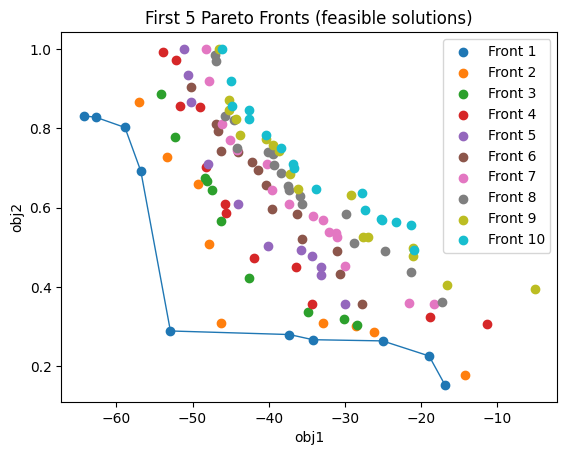

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

df = pd.read_csv("ehvi_results.csv")

feasible_rate = df["feasible"].mean()
print("feasible_rate =", feasible_rate, f"({df['feasible'].sum()}/{len(df)})")

feas = df[df["feasible"] == 1].copy()

if len(feas) == 0:
    print("No feasible solutions -> cannot compute Pareto fronts.")
else:
    F = feas[["obj1", "obj2"]].to_numpy()

    nds = NonDominatedSorting()
    fronts = nds.do(F)

    plt.figure()

    MAX_FRONTS = 10
    for i, front in enumerate(fronts[:MAX_FRONTS]):
        pts = F[front]
        plt.scatter(pts[:, 0], pts[:, 1], label=f"Front {i+1}")

    # connect best front with line
    best = F[fronts[0]]
    best = best[np.argsort(best[:, 0])]
    plt.plot(best[:, 0], best[:, 1], linewidth=1)

    plt.xlabel("obj1")
    plt.ylabel("obj2")
    plt.title("First 5 Pareto Fronts (feasible solutions)")
    plt.legend()
    plt.savefig("pareto_fronts_ehvi.png", dpi=300, bbox_inches="tight")
    plt.show()

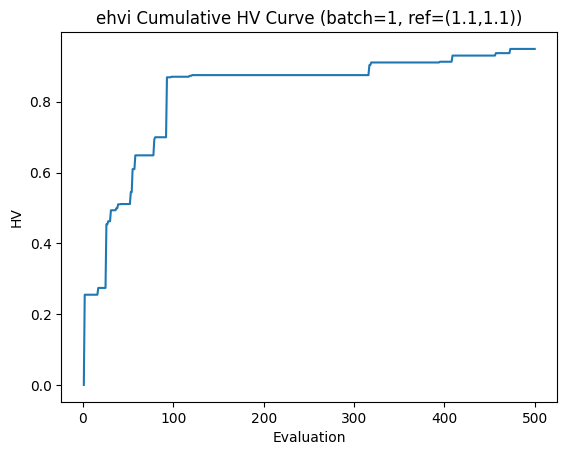

Saved: hv_curve_ehvi_cumulative.png


In [21]:
import matplotlib.pyplot as plt

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV

CSV_PATH = "ehvi_results.csv"
BATCH_SIZE = 1
REF_POINT = np.array([1.1, 1.1], dtype=float)

df = pd.read_csv(CSV_PATH)

f_min = np.array([-67.83963013,   0.153], dtype=float)
f_max = np.array([-0.77212131,  1.0], dtype=float)

denom = f_max - f_min
denom[denom == 0] = 1.0

hv_indicator = HV(ref_point=REF_POINT)

xs, hvs = [], []

n = len(df)
for end in range(BATCH_SIZE, n + 1, BATCH_SIZE):
    cur = df.iloc[:end]
    cur_feas = cur[cur["feasible"] == 1]

    xs.append(end)

    if len(cur_feas) == 0:
        hvs.append(0.0)
        continue

    F = cur_feas[["obj1", "obj2"]].to_numpy(dtype=float)

    fronts = NonDominatedSorting().do(F)
    F_best = F[fronts[0]]

    F_best_norm = (F_best - f_min) / denom

    hv_value = float(hv_indicator(F_best_norm))
    hvs.append(hv_value)

if n % BATCH_SIZE != 0:
    end = n
    cur = df.iloc[:end]
    cur_feas = cur[cur["feasible"] == 1]
    xs.append(end)

    if len(cur_feas) == 0:
        hvs.append(0.0)
    else:
        F = cur_feas[["obj1", "obj2"]].to_numpy(dtype=float)
        fronts = NonDominatedSorting().do(F)
        F_best = F[fronts[0]]
        F_best_norm = (F_best - f_min) / denom
        hvs.append(float(hv_indicator(F_best_norm)))

plt.figure()
plt.plot(xs, hvs)
plt.xlabel("Evaluation")
plt.ylabel("HV")
plt.title(f"ehvi Cumulative HV Curve (batch={BATCH_SIZE}, ref=(1.1,1.1))")
plt.savefig("hv_curve_ehvi_cumulative.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: hv_curve_ehvi_cumulative.png")